# １回目
・学習率を.0.5
・活性化関数をsigmoid

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io

In [2]:
labels= pd.read_csv("train_master.tsv", sep="\t")
master = pd.read_csv("label_master.tsv", sep="\t")
# テスト画像の枚数確認用
sample = pd.read_csv("sample_submit.csv", header=None, sep=",")

print(labels.shape)
print(master.shape)
print(sample.shape)

(50000, 2)
(20, 2)
(10000, 21)


In [3]:
labels.head()

,file_name,label_id
0,train_00000.png,11
1,train_00001.png,15
2,train_00002.png,4
3,train_00003.png,14
4,train_00004.png,1


In [4]:
# ラベルIDとラベル名の紐付け確認
master

,label_id,label_name
0,0,aquatic_mammals
1,1,fish
2,2,flowers
3,3,food_containers
4,4,fruit_and_vegetables
5,5,household_electrical_devices
6,6,household_furniture
7,7,insects
8,8,large_carnivores
9,9,large_man-made_outdoor_things


In [5]:
# labelsデータの順番と不整合にならないよう、ファイルの読み込み順に気を付ける
train_images = []
for fname in labels["file_name"]:
    path = "./train/" + fname
    img = io.imread(path)
    train_images.append(img)
train_images = np.array(train_images)
print(type(train_images), train_images.shape)

<class 'numpy.ndarray'> (50000, 32, 32, 3)


In [6]:
test_images = []
for fname in sample[0]:
    path = "./test/" + fname
    img = io.imread(path)
    test_images.append(img)
test_images = np.array(test_images )
print(type(test_images ), test_images .shape)

<class 'numpy.ndarray'> (10000, 32, 32, 3)


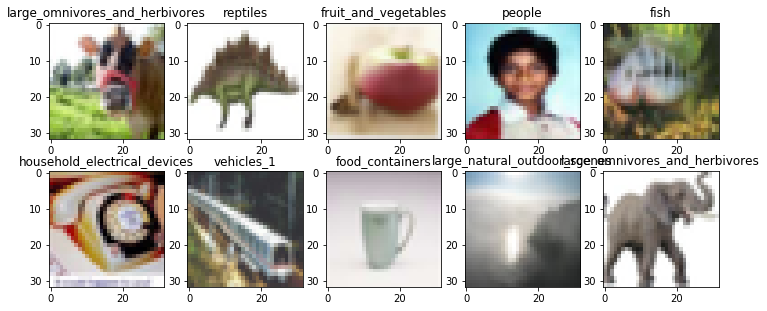

In [7]:
plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    target_id = labels.loc[i,"label_id"]
    label = master[master["label_id"] == target_id]["label_name"].values[0]
    plt.title(label)
    plt.imshow(train_images[i])

In [8]:
labels["label_id"].value_counts()

19    2500
18    2500
1     2500
2     2500
3     2500
4     2500
5     2500
6     2500
7     2500
8     2500
9     2500
10    2500
11    2500
12    2500
13    2500
14    2500
15    2500
16    2500
17    2500
0     2500
Name: label_id, dtype: int64

In [9]:
train_images = train_images / 255
test_images = test_images / 255

In [10]:
y = labels["label_id"]
y

0        11
1        15
2         4
3        14
4         1
         ..
49995    16
49996     7
49997     8
49998     7
49999     1
Name: label_id, Length: 50000, dtype: int64

In [11]:
# 目的変数であるラベルデータをone-hot-encoding
# output = [label1の確率, label2の確率, label3の確率, ..., label20の確率]　に変換
from keras import utils
y_categorical = utils.to_categorical(y)
y_categorical

Using TensorFlow backend.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
y_categorical[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [13]:
# データを構築と検証データの２種類に分割
# 学習データ50000枚中、40000枚を構築データ、残り10000枚を検証データ
# 構築用画像をX_con_image、検証用画像をX_ver_image
# 構築用画像のラベルをy_con_label、検証用画像のラベルをy_vre_label
X_con_image, X_ver_image = np.split(train_images, [40000])
y_con_label, y_ver_label = np.split(y_categorical, [40000])

# 構築用画像
print(X_con_image.shape)
# 検証用画像
print(X_ver_image.shape)
# 構築用画像のラベル
print(y_con_label.shape)
# 検証用画像のラベル
print(y_ver_label.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 20)
(10000, 20)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

In [15]:
model = Sequential()
#　畳み込み層
model.add(Conv2D(filters=6, kernel_size=(3,3), padding="same", input_shape=(32,32,3)))
#　活性化関数＝"sigmoid"
model.add(Activation("sigmoid"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same"))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))
#　畳み込み層やプーリング層と以下の全結合の間には必ず'Flatten'が必要
model.add(Flatten())
# 120ノード全結合層
model.add(Dense(units=120))
model.add(Activation("sigmoid"))
model.add(Dense(units=60))
model.add(Activation("sigmoid"))
# 出力層：今回は2０種類の画像ラベリングなのでノードの数は20
model.add(Dense(units=20))
# 3つ以上の分類をする多値分類の時、'softmax'
model.add(Activation("softmax"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 6)         168       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 12)        660       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 12)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)              

In [17]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.SGD(lr=0.5, momentum=0.9, decay=0.0, nesterov=True),
              metrics=['accuracy']
             )

In [18]:
# 細かく分割した時サイズ
batch_size=100
# パラメータを探索する回数
epochs=10

In [19]:
history = model.fit(X_con_image, y_con_label,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_ver_image, y_ver_label))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 292us/step - loss: 3.0092 - accuracy: 0.0502 - val_loss: 3.0206 - val_accuracy: 0.0484
Epoch 2/10
40000/40000 [==============================] - 12s 300us/step - loss: 3.0063 - accuracy: 0.0507 - val_loss: 3.0074 - val_accuracy: 0.0515
Epoch 3/10
40000/40000 [==============================] - 12s 302us/step - loss: 3.0055 - accuracy: 0.0498 - val_loss: 3.0082 - val_accuracy: 0.0472
Epoch 4/10
40000/40000 [==============================] - 12s 296us/step - loss: 3.0065 - accuracy: 0.0482 - val_loss: 3.0080 - val_accuracy: 0.0472
Epoch 5/10
40000/40000 [==============================] - 12s 306us/step - loss: 3.0061 - accuracy: 0.0503 - val_loss: 3.0128 - val_accuracy: 0.0494
Epoch 6/10
40000/40000 [==============================] - 12s 288us/step - loss: 3.0052 - accuracy: 0.0496 - val_loss: 3.0101 - val_accuracy: 0.0482
Epoch 7/10
40000/40000 [==============================] 

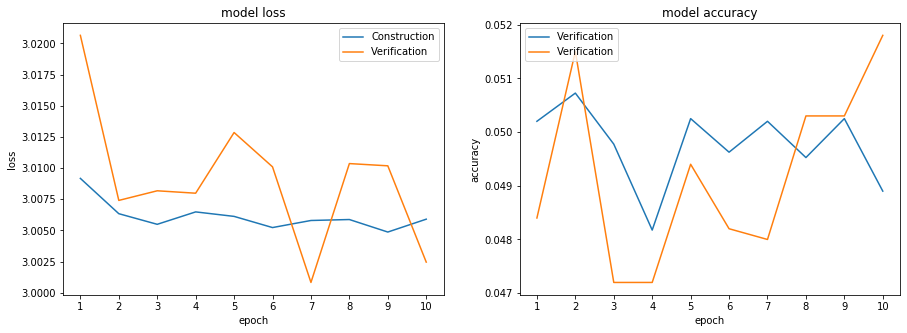

In [30]:
def learning_plot(history, epochs):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(range(1,epochs+1), history.history['loss'])
    plt.plot(range(1,epochs+1), history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.xticks(range(1,epochs+1))
    plt.ylabel('loss')
    plt.legend(['Construction', 'Verification'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(range(1,epochs+1), history.history['accuracy'])
    plt.plot(range(1,epochs+1), history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.xticks(range(1,epochs+1))
    plt.ylabel('accuracy')
    plt.legend(['Verification', 'Verification'], loc='upper left')
    plt.show()  
    
learning_plot(history,epochs)

In [22]:
pred = model.predict(test_images)
pred

array([[0.04889179, 0.04603487, 0.05389638, ..., 0.04840792, 0.03947305,
        0.0405113 ],
       [0.04889173, 0.04603492, 0.05389633, ..., 0.04840765, 0.03947326,
        0.04051019],
       [0.0488917 , 0.04603502, 0.05389614, ..., 0.04840773, 0.03947327,
        0.04051031],
       ...,
       [0.04889165, 0.04603499, 0.0538962 , ..., 0.0484078 , 0.03947341,
        0.04051024],
       [0.04889174, 0.04603487, 0.05389624, ..., 0.04840764, 0.03947326,
        0.04051017],
       [0.04889176, 0.04603492, 0.05389621, ..., 0.04840782, 0.03947326,
        0.04051057]], dtype=float32)

In [23]:
# pred = pred.argmax(axis=1)
# pred

In [28]:
sample[1] = pred
sample.to_csv("submit1_1.csv", sep=",", index=None, header=None)

In [29]:
print(model.evaluate(X_ver_image ,y_ver_label))

10000/10000 [==============================] - 2s 151us/step
[3.002460385131836, 0.05180000141263008]
